## AXIALLY-LOADED BAR PROBLEM - 1D FEM with LINEAR ELEMENTS

#### Let's consider the axially-loaded bar problem given in the figure. The bar has a length of $L$ and its rectangular cross section has a width of $w$ and a height of $h$. A concentrated load $P$ is applied at the right end of the bar, while the left end is fixed, and a distributed load $b(x)$ as a function of position is applied to the bar. The bar is made of a material of Young's Modulus $E$.

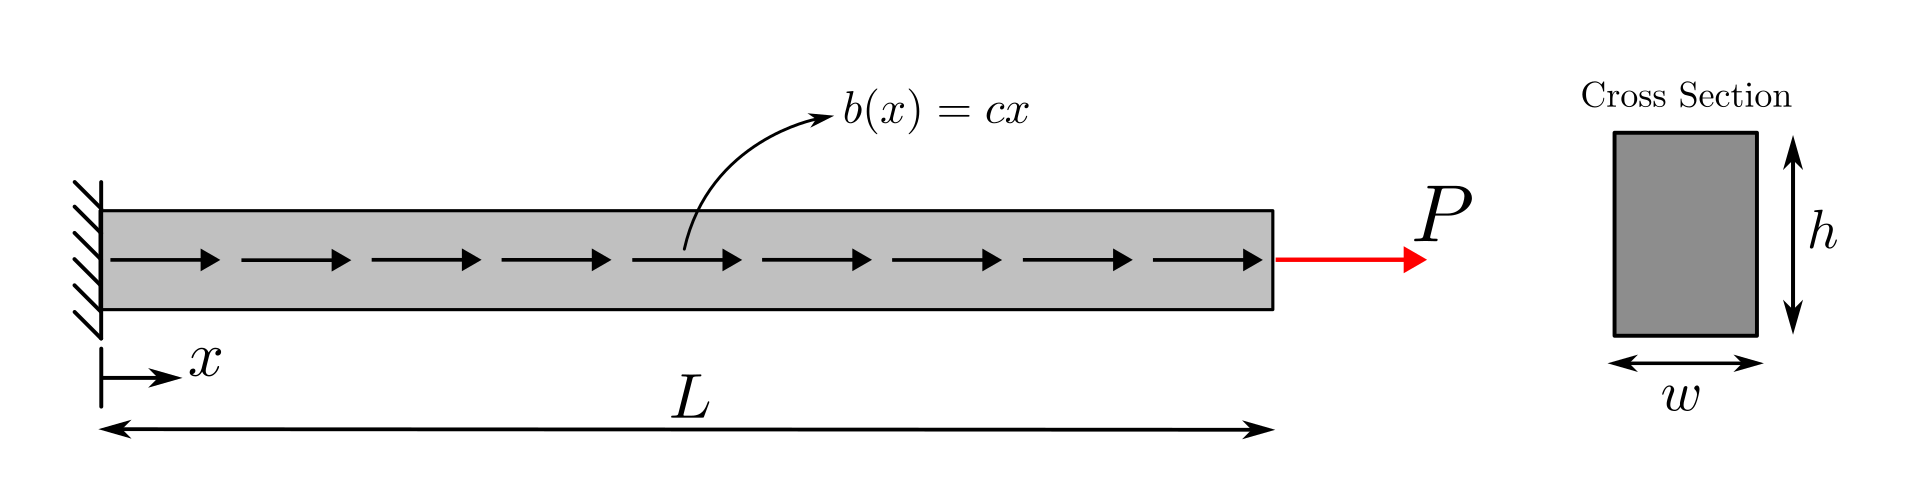

#### Let $L=1$ m, $w=h=0.1$ m, $E=20 \times 10^6$ Pa, $c=10000$ $N/\text{m}^2$, and $P=10000$ N, and write a code which is able to perform FEM solution of the problem with predetermined number of linear elements. The code must apply the Dirichlet BC on the left end by row-column manipulation. Compare your FEM solution with the analytical one.

#### Use the following expression to compute the error between the analytical and numerical solutions:

#### $$\text{ERROR=} \int_0^L \left| u_{FEM} - u_{TRUE} \right| \, dx$$


In [5]:
import numpy as np
import sympy
from sympy import symbols
from sympy.plotting import plot

In [6]:
# Material and Geometric Properties:
L = 1.0
w = 0.1
h = 0.1
E = 20E6
c = 100000
P = 10000
A = w*h

In [7]:
# MESH
ne = 4
x = np.linspace(0,L,ne+1)
conn = np.zeros((ne,2), dtype=int)
for i in range(0,ne):
    conn[i][:] = [i, i+1]
nn = x.shape[0]
ndof = 1

In [8]:
x

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [9]:
c

100000

In [10]:
# FEM Element-by-element assembly
K = np.zeros((ndof*nn,ndof*nn))
F = np.zeros((ndof*nn,1))
# Loop over each element
for i in range(0,ne):
    x1 = x[conn[i,0]]
    x2 = x[conn[i,1]]
    le = x2-x1 # Element Length
    ke = np.array([[1, -1],[-1, 1]])*(E*A/le)
    K[np.ix_(conn[i,:],conn[i,:])] += ke
    F[conn[i,:]] += np.array([[c*x2/2/le*(x2**2-x1**2)-c/3/le*(x2**3-x1**3)],
                             [c/3/le*(x2**3-x1**3)-c*x1/2/le*(x2**2-x1**2)]])
F[-1] += P

In [11]:
K

array([[ 800000., -800000.,       0.,       0.,       0.],
       [-800000., 1600000., -800000.,       0.,       0.],
       [      0., -800000., 1600000., -800000.,       0.],
       [      0.,       0., -800000., 1600000., -800000.],
       [      0.,       0.,       0., -800000.,  800000.]])

In [12]:
F

array([[ 1041.66666667],
       [ 6250.        ],
       [12500.        ],
       [18750.        ],
       [21458.33333333]])

In [13]:
K = np.delete(K,0,0)
K = np.delete(K,0,1)
F = np.delete(F,0,0)

In [14]:
K

array([[1600000., -800000.,       0.,       0.],
       [-800000., 1600000., -800000.,       0.],
       [      0., -800000., 1600000., -800000.],
       [      0.,       0., -800000.,  800000.]])

In [15]:
F

array([[ 6250.        ],
       [12500.        ],
       [18750.        ],
       [21458.33333333]])

In [16]:
np.shape(K)

(4, 4)

In [17]:
u = np.linalg.solve(K,F)

In [18]:
u_FEM = np.zeros((nn,1))
u_FEM[1:] = u

In [19]:
u_FEM

array([[0.        ],
       [0.07369792],
       [0.13958333],
       [0.18984375],
       [0.21666667]])

In [20]:
from sympy import symbols, Function, dsolve, Eq, diff, solve, simplify
import sympy
import matplotlib.pyplot as plt
x_, E_, w_, h_, c_, L_ = symbols('x_ E_ w_ h_ c_ L_')
u_ = Function('u')(x_)
up = u_.diff(x_)
eqn = (E_*(w_*h_)*up).diff(x_) + c_*x_
u_general = dsolve(eqn).rhs
bc1 = Eq(u_general.subs(x_, 0), 0)
bc2 = Eq((E_*(w_*h_)*diff(u_general, x_)).subs(x_, L_), P)
C1, C2 = symbols('C1 C2')
consts = solve([bc1, bc2], (C1, C2))
u_ = u_general.subs(consts)
vals = {E_: E, w_: w, h_: h, c_: c, L_: L}
u_ = u_.subs(vals)

In [21]:
#From Symbolic to Numeric:
from sympy import lambdify 
u_FUNC = lambdify(x_, u_, 'numpy')

In [22]:
from sympy import lambdify
from scipy import integrate
# Error (L1) - Integration with Trapezoidal Rule:
err = 0.0
for i in range(0,ne):
    x1 = x[conn[i,0]]
    x2 = x[conn[i,1]]
    le = x2-x1
    u1 = u_FEM[conn[i,0]]
    u2 = u_FEM[conn[i,1]]
    x_trap = np.linspace(x1, x2, num=51)
    y_trap = abs(u_FUNC(x_trap)-(u1*(x2-x_trap)/le+u2*(x_trap-x1)/le))
    err += integrate.trapezoid(y_trap,x_trap)

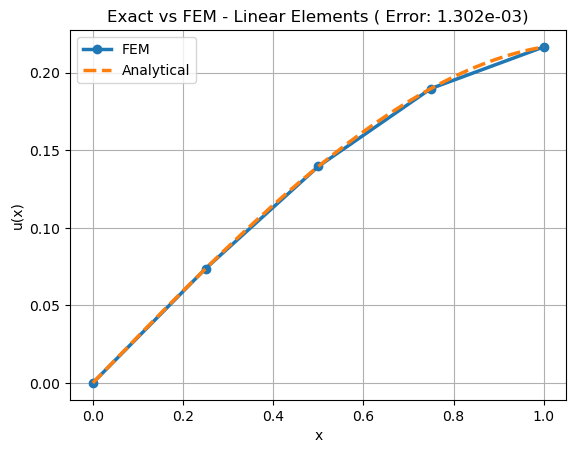

In [23]:
x_TRUE = np.linspace(0, L, 1000)
u_TRUE = u_FUNC(x_TRUE)
plt.figure()
plt.plot(x, u_FEM, 'o-', linewidth=2.5, label='FEM')
plt.plot(x_TRUE, u_TRUE, '--', linewidth=2.5, label='Analytical')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'Exact vs FEM - Linear Elements ( Error: {err:.3e})')
plt.legend()
plt.grid(True)
plt.show()

## Element Force Vector - Analytical Integration

\begin{align}
\begin{bmatrix} f_1 \\ f_2 \end{bmatrix} = \int_{x_1}^{x_2} cx \begin{bmatrix} \phi_1 \\ \phi_2 \end{bmatrix} dx
\end{align}

\begin{align}
f_1 &= \int_{x_1}^{x_2} cx \, \phi_1 \, dx = \int_{x_1}^{x_2} cx \left( \frac{x_2 - x}{\ell_e} \right) dx = \frac{c x_2}{2\ell_e} \left( x_2^2 - x_1^2 \right) - \frac{a}{3 \ell_e} \left( x_1^3-x_2^3 \right) \nonumber \\
f_2 &= \int_{x_1}^{x_2} cx \, \phi_2 \, dx = \int_{x_1}^{x_2} cx \left( \frac{x - x_1}{\ell_e} \right) dx = -\frac{c x_1}{2\ell_e} \left( x_2^2 - x_1^2 \right) + \frac{a}{3 \ell_e} \left( x_1^3-x_2^3 \right) \nonumber
\end{align}